The following is a simulation of network effects on app adoption across Android/IOS platforms to inform the cost/benefit analysis of building a social app taking advantage of IOS features vs a more generic social app that can run on Android and IOS operating systems.

The results show that at reasonable network sizes and time scales, the difference in adoption ratio is not directly proportional to the size of the total network addressed. By breaking networks apart along platform lines, you would not reach the required atomic network size to maintain a positive Allee effect. See the work of Dr. Warder Clyde Allee referenced in relation to social networks by Andrew Chen; essentially big enough networks grow on a logistic curve and become self-sustaining, while networks that don't reach their minimum viable size (atomic network size) naturally fall apart.

In [32]:
#setup
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import networkx as nx
import random 
import math
from IPython.display import clear_output
import time
import os

In [54]:
# Global parameters
network_size = 1000
IOS_weight = 0.65
adoption_probability_raw = 0.01
tick_count = 100
platform_lock = False
fps = 60


In [55]:
###################  TODO  ###################
#fix bug in edge_alpha_choice when platform_lock == True

class Node:
    def __init__(self):
        self.edges = [] #list nodes connected to
        self.degrees = 0 #count of edges
        self.degree_lim = individual_edge_count() #maximum connection number
        self.legalconnections = [] #list of connections which will increase the probability of adoption
        self.platform = "IOS" if random.random() < IOS_weight else "Android"
        self.adoption = False #has the user adopted the service
        self.small_network_size = 4 #the minimum number of legal connections needed to prevent user from dropping service (setting adoption to False)
        self.small_network_tolerance = 14 #the length of time the user will wait before dropping the service 
        self.small_network_time = 0 #the time which the user has had under small_network_tolerance threshold
     
    #the probability on a given tick that a node will adopt the service. 
    def get_adoption_probability(self):
        if platform_lock == True and self.platform == "Android":
            return 0
        else:
            num_connected_adopters = 0
            #the probability of adoption increases on a sigmoid curve based on the number of legal connections. When platform_lock == True, legal connections 
            #can only be between one IOS node and another. Any connection between IOS/Android or Android/Android is not considered legal for the purpose of 
            #increasing adoption probability. 
            #It should be considered to make x the ratio of adopted connectors to a set number, such as 20 (max of max conenctions), as increased network size
            #is likely to drive adoption, and the nature of the social app in question gives it less utility in smaller networks.
            for i in self.legalconnections:
                if i.adoption == True:
                    num_connected_adopters += 1
            x = num_connected_adopters / self.degrees
            return adoption_probability_raw * (1 + math.exp(-x))**(-1)

    #When a user adopts a service which does not meet the requirements of an atomic network (self-sustaining in number, see the work of Dr. Warder Clyde Allee 
    #referenced in relation to social networks by Andrew Chen), they will tend to leave the system after a period. The size is determined by a node's 
    #small_network_size, and the time before they leave is determined by the small_network_tolerance.
    def adoption_lapse(self):
        if self.adoption == True:
            num_connected_adopters = 0
            for i in self.legalconnections:
                    if i.adoption == True:
                        num_connected_adopters += 1
            if num_connected_adopters < self.small_network_size:
                self.small_network_time += 1
            if self.small_network_time >= self.small_network_tolerance:
                self.adoption = False
                self.small_network_time = 0

                
#assign the number of friends a user has in their network when the class instance is instantiated. 
def individual_edge_count():
    #parameters for random amount of friends
    mode = 5 #the expected value
    skewness = 7 #direction and magnitude of distribution skew. Negative is left skewed, positive is right skewed
    kurtosis = 6 #tailedness of distribution
    minimum_value = 1 #maximum friend count possible
    maximum_value = 20 #minimum friend count possible
    show_distribution = False #only required for testing when changing parameters
    # Create the distribution
    x = np.linspace(minimum_value, maximum_value, 1000)
    y = np.exp(-(x-mode)**2/(2*skewness**2))
    y *= (1 + (x-mode)**2/(skewness**2))**(-kurtosis/2)
    y /= np.trapz(y, x)

    # Normalize the probabilities
    y /= y.sum()

    # Plot the distribution if show_distribution is True. 
    if show_distribution:
        plt.plot(x, y)
        plt.title('Weighted Distribution')
        plt.xlabel('Value')
        plt.ylabel('Probability')
        plt.show()

    # Generate a random number from the distribution
    return round(np.random.choice(x, p=y))


def get_legal_connections():
    for node in nodes:
        lc = node.edges.copy()
        if platform_lock == True:
            if node.platform == 'IOS':
                for edge in lc:
                    if node.platform != edge.platform:
                        lc.remove(edge)
                node.legalconnections = lc
            else: node.legalconnections = []
        else:
            node.legalconnections = lc

            
#building the network. This occurs entirely outside of the networkx framework, which is only used for the visualization functions.
def build_network():
    for node in nodes:
        while node in available_nodes:
            #create a list of viable choices that are not 1.) itself 2.) already in its connection list 3.) already full
            choicelist = available_nodes.copy()
            choicelist = [i for i in choicelist if i != node] #removes self from choicelist
            choicelist = [i for i in choicelist if i not in node.edges]  #removes connections that are already on the choice list
            if len(choicelist) == 0:
                break
            #picking a random node from available and adding it to the connections of a given node
            connecting_node = random.choice(choicelist)
            node.edges.append(connecting_node) 
            connecting_node.edges.append(node)
            #updating degree count and removing from available if maxed. This makes sure neither the node in question, no any node which is in the list of choices, 
            #exceeds its conenction limit
            node.degrees += 1
            if node.degrees == node.degree_lim:
                available_nodes.remove(node)
            connecting_node.degrees += 1
            if connecting_node.degrees == connecting_node.degree_lim:
                available_nodes.remove(connecting_node)
        #determine small_network_size (use this if you want a dynamic sns, currently at 1/2 a persons connections)
        #node.small_network_size = math.ceil(node.degrees / 2)
        get_legal_connections()


#This function does not work as expected. Though the simulation works out as expected, the visual graphing does not appropriately assign edge alpha to legal connections. With a
#closed platform (platform_lock == True), only (and all) IOS <---> IOS edges should be dark, but currently there are IOS <---> IOS connections that are light (indicating illegal),
#and Android <---> Anything connections that are dark (indicating legal).
def edge_alpha_choice():  #set edge alphas to be more visible for legal connections
    if platform_lock:
        return [0.3 if edge in legalconnectionlist else 0.1 for edge in G.edges()]
    else: 
        return 0.1


#build the graph for visualization in networkx package. Currently not used because something messes up here
def build_graph():
    #building graph
    edgelist = []
    for node in nodes:
        for edge in node.edges:
            edgelist.append((node,edge))

    #build list of legal connections
    legalconnectionlist = []
    for node in nodes:
        for edge in node.legalconnections:
            legalconnectionlist.append((node,edge))

    G = nx.Graph()
    #because G uses nx.Graph(), it is non-directional, which means dupicates from the edge list (if node1 connects to node2, edgelist contains (node1,node2) AND (node2,node1))
    #are not added, since only one edge can exist between two nodes in a non-directional graph
    G.add_edges_from(edgelist)
    #pos = nx.spring_layout(G, k = .8)
    pos = nx.random_layout(G)
    #setting visual indicators for graph
    node_colors = ["blue" if nodes[i].platform == "IOS" else "orange" for i in range(network_size)]
    node_sizes = [20 for i in range(network_size)]
    return G, pos, node_colors, node_sizes, legalconnectionlist

            
def run_visualization(size, save_gif, adopter_ratio): 
    # Update graph if visualize = True
    global gif_frame
    #create array to feed in to nx.draw_networkx_nodes() function, with nodes getting larger when they have adopted
    node_sizes = [25 if nodes[i].adoption else 10 for i in range(network_size)]
    #create array to feed in to nx.draw_networkx_nodes() function, with nodes getting darker when they have adopted
    node_alpha = [1 if nodes[i].adoption else .3 for i in range(network_size)]
    clear_output(wait=True)
    #extra graph stuff
    platform_state_for_title = 'Closed Platform' if platform_lock == True else 'Open Platform'
    title = 'Service Adoption with '+platform_state_for_title+'\nTime = '+str(gif_frame+1)+'\nAdoption Ratio = '+str(adopter_ratio)
    plt.title(title)
    #drawing the actual graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Reds, node_shape="o", alpha=node_alpha)
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha_choice(), width=0.5)
    plt.axis('off')
    plt.rcParams['figure.figsize'] = [size[0],size[1]]
    #this works but the actual gif creation does not so you can ignore it.
    if save_gif == True:
        plt.savefig(os.path.join('###subfolder_path###', f'frame_{gif_frame}.png'))
        #add gif creation within this function later
    gif_frame += 1
    plt.show()
    time.sleep(1/fps)
    
    
def run_simulation(reset=True, visualize=False, size=(10, 10), save_gif=False, gif_duration=10, use_existing_graph=False):
    global gif_frame
    adopters_count = 0
    adopter_ratio = 0
    build_network()

    #reset simulation (adoption = False), otherwise it will compound (next tick_count days)
    if reset:
        for i in range(network_size):
            nodes[i].adoption = False

    if not use_existing_graph:
        global G, pos, node_colors, node_sizes, legalconnectionlist
        G, pos, node_colors, node_sizes, legalconnectionlist = build_graph()
        
    #build the graph
    build_graph() #this isn't working; see below
    # Simulate adoption and update graph
    gif_frame = 0
    for i in range(tick_count):
        for node in nodes:
            if node.adoption == False:
                p = node.get_adoption_probability()
                if random.random() < p:
                    node.adoption = True
            else:
                node.adoption_lapse() #if node has already adopted, check its network size and tolerance, incrememnt tolerance if required; unadopt if criteria met
                pass    
        adopters_count = sum(1 for node in nodes if node.adoption == True)
        adopter_ratio = adopters_count/network_size
        if visualize == True:
            run_visualization(size, save_gif, adopter_ratio)
    return([platform_lock, adopter_ratio])


#create nodes
nodes = [Node() for i in range(network_size)]
available_nodes = nodes.copy() #all nodes which are available (not at max degrees)

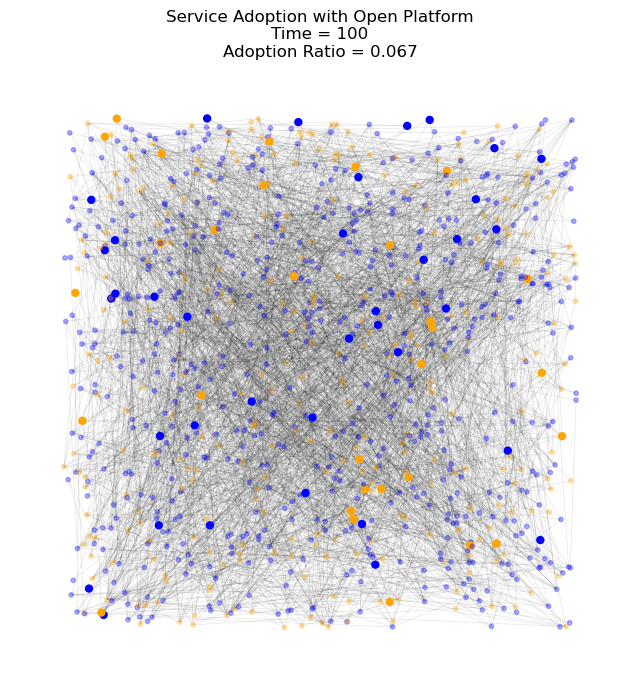

[False, 0.067]

In [56]:
run_simulation(reset=True,size=(8,8),visualize=True,save_gif=False)

In [30]:
#testing the distribution of simulation results

sample_count = 1000 #how many of each iteration will be simulated
df = pd.DataFrame()
df['platform'] = []
df['adoption_percentage'] = []

platform_lock = True
for i in range(sample_count):
    df_add = run_simulation(reset = True, visualize=False)
    df.loc[len(df)] = df_add

platform_lock = False
for i in range(sample_count):
    df_add = run_simulation(reset = True, visualize = False)
    df.loc[len(df)] = df_add

#increment file name with leading zeros (three digit file number)
i = 0
while os.path.exists("platform_schism_sim_%03d.csv" % i):
    i += 1
filename = "platform_schism_sim_%03d.csv" % i

df.to_csv(filename, index=False)